In [3]:
import pandas as pd 
import numpy as np
from utils import convert_distance, extract_price_robust

In [5]:
df = pd.read_csv('../data/cars_2024_clean.csv')

In [6]:
# Apply conversion
df['converted_km'] = df['mileage'].apply(convert_distance)

In [8]:
df = df[['enginetype', 'city',
       'year', 'car', 'engine', 'converted_km', 'price']]
df['price'] = df['price'].apply(extract_price_robust)
df.dropna(inplace=True)


df.shape

(804, 7)

In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculate Mean Absolute Percentage Error (MAPE)"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

# Fix data types - convert all numeric columns to float
def fix_data_types(df):
    """Convert all numeric columns to float and handle object types"""
    df_fixed = df.copy()
    
    # Convert year and engine to numeric, handling any errors
    df_fixed['year'] = pd.to_numeric(df_fixed['year'], errors='coerce')
    df_fixed['engine'] = pd.to_numeric(df_fixed['engine'], errors='coerce')
    
    # Fill any NaN values with the median of the column
    numeric_cols = ['year', 'engine', 'converted_km', 'price']
    for col in numeric_cols:
        if col in df_fixed.columns:
            median_val = df_fixed[col].median()
            df_fixed[col] = df_fixed[col].fillna(median_val).astype(float)
    
    return df_fixed

# Apply data type fixes
df_imp_fixed = fix_data_types(df_imp)

# Preprocessing: Encode categorical variables
label_encoders = {}
categorical_cols = ['enginetype', 'city', 'car']

for col in categorical_cols:
    le = LabelEncoder()
    df_imp_fixed[col] = le.fit_transform(df_imp_fixed[col].astype(str))
    label_encoders[col] = le

# Prepare features and target
X = df_imp_fixed.drop('price', axis=1)
y = df_imp_fixed['price']

# Ensure all features are numeric
X = X.astype(float)

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Feature data types:\n{X_train.dtypes}")

# Initialize Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on training data
rf.fit(X_train, y_train)

# Predict on test data
y_pred = rf.predict(X_test)

# Calculate MAPE on test set
test_mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"\nTest set MAPE: {test_mape:.2f}%")

# Additional evaluation metrics
test_mae = mean_absolute_error(y_test, y_pred)
print(f"Test set MAE: {test_mae:.2f}")

# Perform cross-validation on training data for more robust evaluation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_mape_scores = -cross_val_score(rf, X_train, y_train, 
                                 cv=kf, scoring='neg_mean_absolute_percentage_error')

print(f"\nCross-validation MAPE scores: {cv_mape_scores}")
print(f"Average CV MAPE: {np.mean(cv_mape_scores):.2f}% (+/- {np.std(cv_mape_scores):.2f}%)")


Training set size: 643 samples
Test set size: 161 samples
Feature data types:
enginetype      float64
city            float64
year            float64
car             float64
engine          float64
converted_km    float64
dtype: object

Test set MAPE: 34.42%
Test set MAE: 34927.67

Cross-validation MAPE scores: [0.28278325 0.27125274 0.2622989  0.28695471 0.27757495]
Average CV MAPE: 0.28% (+/- 0.01%)



Feature Importances:
        feature  importance
2          year    0.437553
4        engine    0.325796
5  converted_km    0.107290
3           car    0.081171
1          city    0.037525
0    enginetype    0.010665


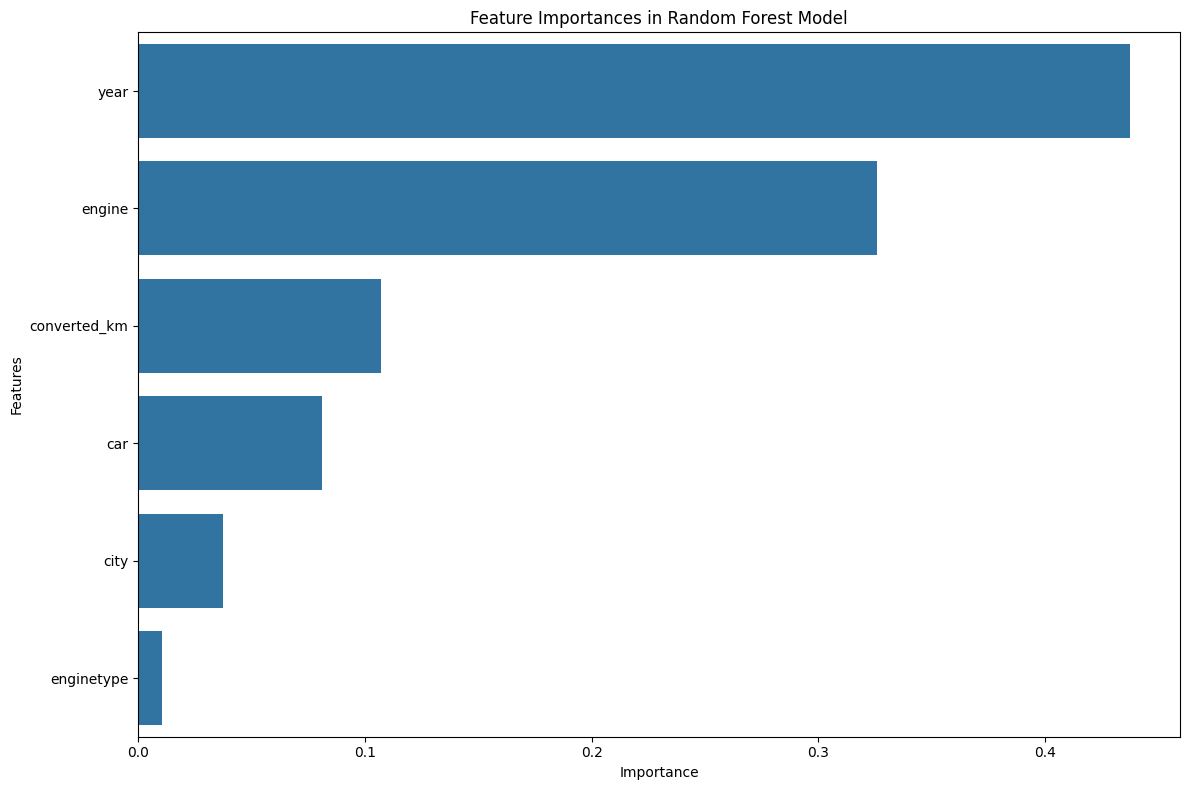

In [10]:

# Get feature importances
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)

# Visualize feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Feature Importances in Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

<h2> Saving the model and the other needed files </h2>

In [13]:
import pandas as pd
import numpy as np
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

# Load your dataset
# df = pd.read_csv('your_data.csv')

def fix_data_types(df):
    """Convert all numeric columns to float and handle object types"""
    df_fixed = df.copy()
    
    # Convert year and engine to numeric, handling any errors
    df_fixed['year'] = pd.to_numeric(df_fixed['year'], errors='coerce')
    
    # Handle engine column - convert to numeric, non-numeric becomes NaN
    df_fixed['engine'] = pd.to_numeric(df_fixed['engine'], errors='coerce')
    
    # For electric cars, we'll set engine size to 0 (or you can use a different strategy)
    # Identify electric cars and set appropriate engine value
    electric_mask = df_fixed['enginetype'].str.contains('էլեկտրական', na=False)
    df_fixed.loc[electric_mask, 'engine'] = 0.0  # Electric cars have 0L engine
    
    # Fill any NaN values with the median of the column
    numeric_cols = ['year', 'engine', 'converted_km', 'price']
    for col in numeric_cols:
        if col in df_fixed.columns:
            median_val = df_fixed[col].median()
            df_fixed[col] = df_fixed[col].fillna(median_val).astype(float)
    
    return df_fixed

# Apply data type fixes
df_fixed = fix_data_types(df)

# Encode categorical variables and save encoders
label_encoders = {}
categorical_cols = ['enginetype', 'city', 'car']

for col in categorical_cols:
    le = LabelEncoder()
    df_fixed[col] = le.fit_transform(df_fixed[col].astype(str))
    label_encoders[col] = le

# Prepare features and target
X = df_fixed.drop('price', axis=1).astype(float)
y = df_fixed['price']

# Train and save the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Save the model
with open('car_price_model.pkl', 'wb') as f:
    pickle.dump(rf, f)

# Save label encoders
with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

# Get and save distinct values from original data for dropdowns
# For engine, we need to handle both numeric and string values
def get_engine_values(df):
    """Extract numeric engine values, handle electric cars"""
    engine_values = []
    for val in df['engine']:
        try:
            engine_values.append(float(val))
        except (ValueError, TypeError):
            # For electric cars or non-numeric values, use 0
            engine_values.append(0.0)
    return engine_values

engine_values = get_engine_values(df)

distinct_values = {
    'enginetype': sorted(df['enginetype'].astype(str).unique().tolist()),
    'city': sorted(df['city'].astype(str).unique().tolist()),
    'car': sorted(df['car'].astype(str).unique().tolist()),
    'min_year': int(df_fixed['year'].min()),
    'max_year': int(df_fixed['year'].max()),
    'min_engine': float(min(engine_values)),
    'max_engine': float(max(engine_values)),
    'min_km': float(df_fixed['converted_km'].min()),
    'max_km': float(df_fixed['converted_km'].max())
}

with open('distinct_values.pkl', 'wb') as f:
    pickle.dump(distinct_values, f)

# Also save the mapping for electric cars for reference
electric_car_info = {
    'electric_types': ['էլեկտրական'],
    'default_engine_value': 0.0
}

with open('electric_car_info.pkl', 'wb') as f:
    pickle.dump(electric_car_info, f)

print("Model and data distinct values saved successfully!")
print(f"Engine range: {distinct_values['min_engine']} - {distinct_values['max_engine']}")

Model and data distinct values saved successfully!
Engine range: 0.0 - 5.7
